# Imports

Requirements:
- python 3.6
- numpy
- matplotlib
- seaborn
- pytorch
- torchvision
- tqdm
- joblib

Note: some of the images won't show on github, but they should if you download the notebook locally and use a recent enough version of jupyter.

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
import torch
torch.__version__

'1.7.1'

In [10]:
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm
import multiprocessing
import os.path
import csv
import copy
import joblib
from torchvision import datasets
import torchvision
import seaborn as sns; sns.set(color_codes=True)
sns.set_style("white")
from pdb import set_trace as bp

In [6]:
for i in tqdm(range(10)):
    pass

  0%|          | 0/10 [00:00<?, ?it/s]

In [11]:
USE_CUDA = torch.cuda.is_available()

def w(v):
    if USE_CUDA:
        return v.cuda()
    return v
USE_CUDA

True

In [12]:
# !mkdir _cache
cache = joblib.Memory(location='_cache', verbose=0)

In [13]:
from meta_module import *

# Intro

This notebook is a reproduction of the paper "Learning to Learn by Gradient Descent by Gradient Descent" (https://arxiv.org/abs/1606.04474). 

In a word, this paper is trying to replace the optimizers normally used for neural networks (eg Adam, RMSprop, SGD etc.) by a recurrent neural network: after all, gradient descent is fundamentally a **sequence** of updates (from the output layer of the neural net back to the input), in between which a **state** must be stored. Thus we can think of an optimizer as a mini-RNN. The idea in this paper is to actually train that RNN instead of using a generic algorithm like Adam/SGD/etc..

## Loss

The loss function described in the paper seems complicated, but in reality it is very simple: all it is saying is that the loss of the optimizer is the sum of the losses of the optimizee as it learns. The paper includes some notion of weighing but gives a weight of 1 to everything, so that it indeed is just the sum.

$$\mathcal{L}(\phi) = \mathbb{E}_f \left[ \sum_{t=1}^T w_t f(\theta_t) \right]$$
where
$$\theta_{t+1} = \theta_t + g_t$$
$$\begin{bmatrix} g_t \\ h_{t+1} \end{bmatrix} = m(\nabla_t, h_t, \phi)$$

The $w_t$ are arbitrary weights for each timestep. If we only set the last $w_t$ to 1 and the rest to 0, we are optimizing for the best **final** result with our optimizee. This seems reasonable, but it makes it much harder to train. Instead we will use $w_t$ = 1 for all $t$. $\nabla_t = \nabla_{\theta} f(\theta_t)$.

$f$ is the *optimizee* function, and $\theta_t$ is its parameters at time $t$.
$m$ is the *optimizer* function, $\phi$ is its parameters. $h_t$ is its state at time $t$. $g_t$ is the update it outputs at time $t$.

The plan is thus to use gradient descent on $\phi$ in order to minimize $\mathcal{L}(\phi)$, which should give us an optimizer that is capable of optimizing $f$ efficiently.

As the paper mention, it is important that the gradients in dashed lines in the figure below are **not** propagated during gradient descent.

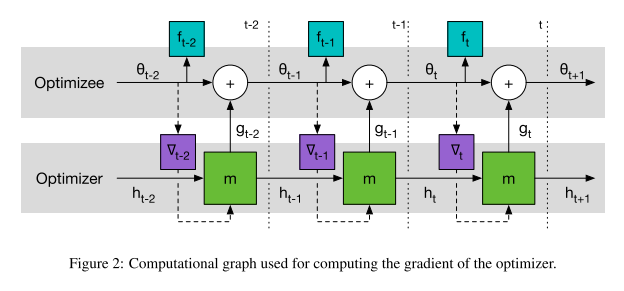

Basically this is nothing we wouldn't expect: the loss of the optimizer neural net is simply the average training loss of the optimizee as it is trained by the optimizer. The optimizer takes in the gradient of the current coordinate of the optimizee as well as its previous state, and outputs a suggested update that we hope will reduce the optimizee's loss as fast as possible.

## Coordinatewise

Informally speaking, coordinatewise optimization is to optimize each parameter by its own state. Any momentum or energy term used in the optimization is based on each parameter's own history, independent on others. Each parameter's optimization state is not shared across other coordinates.

The precondition assumed in ths paper, is that all parameters share the same weights in the LSTM meta optimizer.

# Implementation

As we perform operations, Pytorch builds the computational graph of the operations we perform. However, there are some variables that we want to detach from the graph at various points, specifically we want to pretend that the gradients are inputs (as specified in the previous image) that come from nowhere, instead of coming from the rest of the computational graph as they really do: this means we want to **detach** the gradients from the graph. Likewise, when every 20 steps we perform backpropagation on the optimizer network, we want the current hidden states and cell states, as well as the parameters of the optimizee to "forget" that they are dependent on previous steps in the graph. For all of this, I created a function called `detach_var` which creates a new Variable from the current variable's data, and makes sure that its gradients are still kept. This is different from the `.detach()` function in Pytorch which does not quite forget the original graph and also does not guarantee that the gradients will be there.

In [14]:
def detach_var(v):
    var = w(Variable(v.data, requires_grad=True))
    var.retain_grad()
    return var

import functools
torch.set_default_tensor_type('torch.cuda.FloatTensor')
def rsetattr(obj, attr, val):
    pre, _, post = attr.rpartition('.')
    return setattr(rgetattr(obj, pre) if pre else obj, post, val)

# using wonder's beautiful simplification: https://stackoverflow.com/questions/31174295/getattr-and-setattr-on-nested-objects/31174427?noredirect=1#comment86638618_31174427

def rgetattr(obj, attr, *args):
    def _getattr(obj, attr):
        return getattr(obj, attr, *args)
    return functools.reduce(_getattr, [obj] + attr.split('.'))

def do_fit(opt_net, meta_opt, target_cls, target_to_opt, unroll, optim_it, n_epochs, out_mul, should_train=True):
    if should_train:
        opt_net.train()
    else:
        opt_net.eval()
        unroll = 1
    
    target = target_cls(training=should_train)
    optimizee = w(target_to_opt())
    n_params = 0
    for name, p in optimizee.all_named_parameters():
        n_params += int(np.prod(p.size()))
    hidden_states = [w(Variable(torch.zeros(n_params, opt_net.hidden_sz))) for _ in range(2)]
    cell_states = [w(Variable(torch.zeros(n_params, opt_net.hidden_sz))) for _ in range(2)]
    all_losses_ever = []
    if should_train:
        meta_opt.zero_grad()
    all_losses = None
    for iteration in range(1, optim_it + 1):
        loss = optimizee(target)
#         print(f'optimizee is running on {next(optimizee.parameters()).device}')
        
        if all_losses is None:
            all_losses = loss
        else:
            all_losses += loss
        
        all_losses_ever.append(loss.data.cpu().numpy())
        loss.backward(retain_graph=should_train)

        offset = 0
        result_params = {}
        hidden_states2 = [w(Variable(torch.zeros(n_params, opt_net.hidden_sz))) for _ in range(2)]
        cell_states2 = [w(Variable(torch.zeros(n_params, opt_net.hidden_sz))) for _ in range(2)]
        for name, p in optimizee.all_named_parameters():
            cur_sz = int(np.prod(p.size()))
            # We do this so the gradients are disconnected from the graph but we still get
            # gradients from the rest
            gradients = detach_var(p.grad.view(cur_sz, 1))
            updates, new_hidden, new_cell = opt_net(
                gradients,
                [h[offset:offset+cur_sz] for h in hidden_states],
                [c[offset:offset+cur_sz] for c in cell_states]
            )
            for i in range(len(new_hidden)):
                hidden_states2[i][offset:offset+cur_sz] = new_hidden[i]
                cell_states2[i][offset:offset+cur_sz] = new_cell[i]
            result_params[name] = p + updates.view(*p.size()) * out_mul
            result_params[name].retain_grad()
            
            offset += cur_sz
        
        if iteration % unroll == 0:
#             print(f'meta_opt is running on {next(optimizee.parameters()).device}')
        
            if should_train:
                meta_opt.zero_grad()
                all_losses.backward()
                meta_opt.step()
            
            all_losses = None

            optimizee = w(target_to_opt())
            optimizee.load_state_dict(result_params)
            optimizee.zero_grad()
            hidden_states = [detach_var(v) for v in hidden_states2]
            cell_states = [detach_var(v) for v in cell_states2]
            
        else:
            for name, p in optimizee.all_named_parameters():
                rsetattr(optimizee, name, result_params[name])
            assert len(list(optimizee.all_named_parameters()))
            hidden_states = hidden_states2
            cell_states = cell_states2
            
    return all_losses_ever


@cache.cache
def fit_optimizer(target_cls, target_to_opt, preproc=False, unroll=20, optim_it=100, n_epochs=20, n_tests=100, lr=0.001, out_mul=1.0):
    opt_net = w(Optimizer(preproc=preproc))
    meta_opt = optim.Adam(opt_net.parameters(), lr=lr)
    
    best_net = None
    best_loss = 100000000000000000
    
    for _ in tqdm(range(n_epochs), 'epochs'):
        for _ in tqdm(range(20), 'iterations'):
            do_fit(opt_net, meta_opt, target_cls, target_to_opt, unroll, optim_it, n_epochs, out_mul, should_train=True)
        
        loss = (np.mean([
            np.sum(do_fit(opt_net, meta_opt, target_cls, target_to_opt, unroll, optim_it, n_epochs, out_mul, should_train=False))
            for _ in tqdm(range(n_tests), 'tests')
        ]))
        print(loss)
        if loss < best_loss:
            print(best_loss, loss)
            best_loss = loss
            best_net = copy.deepcopy(opt_net.state_dict())
            
    return best_loss, best_net
  


# Experiment repro

In [15]:

class Optimizer(nn.Module):
    def __init__(self, preproc=False, hidden_sz=20, preproc_factor=10.0):
        super().__init__()
        self.hidden_sz = hidden_sz
        if preproc:
            self.recurs = nn.LSTMCell(2, hidden_sz)
        else:
            self.recurs = nn.LSTMCell(1, hidden_sz)
        self.recurs2 = nn.LSTMCell(hidden_sz, hidden_sz)
        self.output = nn.Linear(hidden_sz, 1)
        self.preproc = preproc
        self.preproc_factor = preproc_factor
        self.preproc_threshold = np.exp(-preproc_factor)
        
    def forward(self, inp, hidden, cell):
        if self.preproc:
            # Implement preproc described in Appendix A
            
            # Note: we do all this work on tensors, which means
            # the gradients won't propagate through inp. This
            # should be ok because the algorithm involves
            # making sure that inp is already detached.
            inp = inp.data
            inp2 = w(torch.zeros(inp.size()[0], 2))
            keep_grads = (torch.abs(inp) >= self.preproc_threshold).squeeze()
            inp2[:, 0][keep_grads] = (torch.log(torch.abs(inp[keep_grads]) + 1e-8) / self.preproc_factor).squeeze()
            inp2[:, 1][keep_grads] = torch.sign(inp[keep_grads]).squeeze()
            
            inp2[:, 0][~keep_grads] = -1
            inp2[:, 1][~keep_grads] = (float(np.exp(self.preproc_factor)) * inp[~keep_grads]).squeeze()
            inp = w(Variable(inp2))
        hidden0, cell0 = self.recurs(inp, (hidden[0], cell[0]))
        hidden1, cell1 = self.recurs2(hidden0, (hidden[1], cell[1]))
        return self.output(hidden1), (hidden0, hidden1), (cell0, cell1)
    

In [20]:
@cache.cache
def fit_normal(target_cls, target_to_opt, opt_class, n_tests=100, n_epochs=100, **kwargs):
    results = []
    for i in tqdm(range(n_tests), 'tests'):
        target = target_cls(training=False)
        optimizee = w(target_to_opt())
        optimizer = opt_class(optimizee.parameters(), **kwargs)
        total_loss = []
        for _ in range(n_epochs):
            loss = optimizee(target)
            
            total_loss.append(loss.data.cpu().numpy())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        results.append(total_loss)
    return results

def find_best_lr_normal(target_cls, target_to_opt, opt_class, **extra_kwargs):
    best_loss = 1000000000000000.0
    best_lr = 0.0
    for lr in tqdm([1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001], 'Learning rates'):
        try:
            loss = best_loss + 1.0
            loss = np.mean([np.sum(s) for s in fit_normal(target_cls, target_to_opt, opt_class, lr=lr, **extra_kwargs)])
        except RuntimeError as ex:
            print(ex)
        if loss < best_loss:
            best_loss = loss
            best_lr = lr
    return best_loss, best_lr

In [16]:
NORMAL_OPTS = [(optim.Adam, {}), (optim.RMSprop, {}), (optim.SGD, {'momentum': 0.9}), (optim.SGD, {'nesterov': True, 'momentum': 0.9})]
OPT_NAMES = ['ADAM', 'RMSprop', 'SGD', 'NAG']

## MNIST

Now we move on to MNIST. Because all the rest of our code is implemented, we just need to implement the network specified in the paper, namely a single hidden layer, sigmoid, 20 hidden units network. We make it easy to change sigmoid to some other activation, add layers, and change the number of units, because all of these are attempted in the paper.

In [17]:
class MNISTLoss:
    def __init__(self, training=True):
        dataset = datasets.MNIST(
            './learning_by_grad_by_grad_repro-master/mnist', train=True, download=False,
            transform=torchvision.transforms.ToTensor()
        )
        indices = list(range(len(dataset)))
        np.random.RandomState(10).shuffle(indices)
        if training:
            indices = indices[:len(indices) // 2]
        else:
            indices = indices[len(indices) // 2:]

        self.loader = torch.utils.data.DataLoader(
            dataset, batch_size=128,
            sampler=torch.utils.data.sampler.SubsetRandomSampler(indices))

        self.batches = []
        self.cur_batch = 0
        
    def sample(self):
        if self.cur_batch >= len(self.batches):
            self.batches = []
            self.cur_batch = 0
            for b in self.loader:
                self.batches.append(b)
        batch = self.batches[self.cur_batch]
        self.cur_batch += 1
        return batch

class MNISTNet(MetaModule):
    def __init__(self, layer_size=20, n_layers=1, **kwargs):
        super().__init__()

        inp_size = 28*28
        self.layers = {}
        for i in range(n_layers):
            self.layers[f'mat_{i}'] = MetaLinear(inp_size, layer_size)
            inp_size = layer_size

        self.layers['final_mat'] = MetaLinear(inp_size, 10)
        self.layers = nn.ModuleDict(self.layers)

        self.activation = nn.Sigmoid()
        self.loss = nn.NLLLoss()

    def all_named_parameters(self):
        return [(k, v) for k, v in self.named_parameters()]
    
    def forward(self, loss):
        inp, out = loss.sample()
        inp = w(Variable(inp.view(inp.size()[0], 28*28)))
        out = w(Variable(out))

        cur_layer = 0
        while f'mat_{cur_layer}' in self.layers:
            inp = self.activation(self.layers[f'mat_{cur_layer}'](inp))
            cur_layer += 1

        inp = F.log_softmax(self.layers['final_mat'](inp), dim=1)
        l = self.loss(inp, out)
        return l

Like before, we find a promising learning rate (0.001) using a small number of epochs (10) and optimize it fully using more epochs (50).

In [18]:
class MNISTNet2Layer(MNISTNet):
    def __init__(self, *args, **kwargs):
        super().__init__(n_layers=2, *args, **kwargs)
        
class MNISTNetBig(MNISTNet):
    def __init__(self, *args, **kwargs):
        super().__init__(layer_size=40, *args, **kwargs)
        
class MNISTRelu(MNISTNet):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.activation = nn.ReLU()

In [16]:
fits = []
for lr in tqdm(sorted([1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001], key=lambda x: np.abs(x - 0.003)), 'all'):
    print('Trying lr:', lr)
    fits.append(fit_optimizer(MNISTLoss, MNISTRelu, lr=lr, out_mul=0.1, preproc=True, n_tests=5, n_epochs=10))
    print(fits[-1][0])

all:   0%|          | 0/11 [00:00<?, ?it/s]

Trying lr: 0.003
54.075623
Trying lr: 0.001
230.30244
Trying lr: 0.0003
230.27686
Trying lr: 0.0001


epochs:   0%|          | 0/10 [00:00<?, ?it/s]

iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

253.58687
100000000000000000 253.58687


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

248.60196
253.58687 248.60196


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

227.73201
248.60196 227.73201


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

148.63358
227.73201 148.63358


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

126.56673
148.63358 126.56673


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

98.32987
126.56673 98.32987


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

94.82291
98.32987 94.82291


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

89.630905
94.82291 89.630905


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

86.88956
89.630905 86.88956


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

86.51668
86.88956 86.51668
86.51668
Trying lr: 3e-05


epochs:   0%|          | 0/10 [00:00<?, ?it/s]

iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

230.97128
100000000000000000 230.97128


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

230.69763
230.97128 230.69763


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

230.69116
230.69763 230.69116


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

109.98763
230.69116 109.98763


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

104.050354
109.98763 104.050354


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

102.45308
104.050354 102.45308


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

103.841446


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

100.890205
102.45308 100.890205


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

101.07597


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

101.53203
100.890205
Trying lr: 1e-05


epochs:   0%|          | 0/10 [00:00<?, ?it/s]

iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

1106.4495
100000000000000000 1106.4495


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

412.2076
1106.4495 412.2076


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

418.90073


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

265.38745
412.2076 265.38745


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

227.18991
265.38745 227.18991


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

332.1771


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

192.14285
227.18991 192.14285


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

183.23666
192.14285 183.23666


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

186.15178


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

168.90445
183.23666 168.90445
168.90445
Trying lr: 0.01


epochs:   0%|          | 0/10 [00:00<?, ?it/s]

iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

230.50972
100000000000000000 230.50972


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

230.30801
230.50972 230.30801


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

230.97986


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

230.50488


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

230.53638


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

230.64954


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

230.69339


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

230.62553


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

230.46317


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

230.45068
230.30801
Trying lr: 0.03


epochs:   0%|          | 0/10 [00:00<?, ?it/s]

iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

60.270226
100000000000000000 60.270226


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

73.26105


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

295.77768


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

230.40364


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

230.3907


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

230.37798


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

230.43486


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

230.30997


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

230.3417


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

230.3411
60.270226
Trying lr: 0.1


epochs:   0%|          | 0/10 [00:00<?, ?it/s]

iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

230.33134
100000000000000000 230.33134


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

230.4548


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

230.31631
230.33134 230.31631


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

230.33052


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

230.36235


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

230.3534


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

230.27397
230.31631 230.27397


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

230.31148


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

230.35132


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

230.31633
230.27397
Trying lr: 0.3


epochs:   0%|          | 0/10 [00:00<?, ?it/s]

iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

232.32747
100000000000000000 232.32747


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

232.49731


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

231.09982
232.32747 231.09982


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

230.8035
231.09982 230.8035


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

230.7181
230.8035 230.7181


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

230.49731
230.7181 230.49731


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

231.06201


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

230.8208


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

230.66353


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

230.97632
230.49731
Trying lr: 1.0


epochs:   0%|          | 0/10 [00:00<?, ?it/s]

iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

232.95444
100000000000000000 232.95444


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

231.57793
232.95444 231.57793


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

230.94878
231.57793 230.94878


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

230.89824
230.94878 230.89824


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

230.93112


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

230.89636
230.89824 230.89636


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

230.71143
230.89636 230.71143


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

230.74081


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

231.12773


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

230.84956
230.71143


In [17]:
torch.save(fits, 'all-relu-fits.pt')

In [20]:
lrs = list(sorted([1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001], key=lambda x: np.abs(x - 0.003)))
mixed = zip(lrs, fits)
mixed = sorted(mixed, key=lambda x: x[1][0])
# mixed

In [21]:
torch.save(mnist_optimizer, 'grad-mnist-relu.pt')


In [11]:
mnist_optimizer = torch.load('grad-mnist-model.pt')

In [19]:
loss, mnist_optimizer = fit_optimizer(MNISTLoss, MNISTRelu, lr=0.003, n_epochs=50, n_tests=20, out_mul=0.1, preproc=True)

print(loss)

epochs:   0%|          | 0/50 [00:00<?, ?it/s]

iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

185.78214
100000000000000000 185.78214


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

62.855522
185.78214 62.855522


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

64.16704


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

73.61837


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

78.9356


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

227.3949


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

230.37434


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

230.36325


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

230.36572


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

230.3853


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

230.36203


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

230.39214


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

230.34802


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

230.35922


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

230.35294


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

230.366


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

230.37027


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

230.3529


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

230.36874


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

230.35623


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

230.33533


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

230.34648


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

230.35104


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

230.35703


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

230.33347


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

230.3501


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

230.34612


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

230.3468


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

228.35678


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

227.97205


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

229.08379


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

230.36475


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

229.13135


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

230.49214


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

230.4395


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

230.38982


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

230.32312


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

230.38156


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

230.38489


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

230.35551


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

230.37265


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

230.39384


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

230.37471


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

230.39055


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

230.39194


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

230.36826


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

230.37971


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

230.37936


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

230.34204


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

230.35855
62.855522


We find the best learning rates for the competitors...

In [ ]:
for opt, kwargs in NORMAL_OPTS:
    print(find_best_lr_normal(MNISTLoss, MNISTNet, opt, **kwargs, n_tests=10))
    

And plot! for context, the graph in the original paper looks like this:

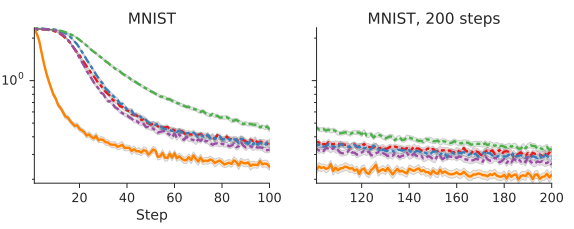

Again we get similar results!!!

In [21]:
QUAD_LRS = [0.03, 0.01, 1.0, 1.0]
N_TESTS = 100

fit_data = np.zeros((N_TESTS, 200, len(OPT_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(MNISTLoss, MNISTNet, opt, lr=lr, n_tests=N_TESTS, n_epochs=200, **extra_kwargs))

tests:   0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [22]:
@cache.cache
def get_fit_dict_test(n_tests, opt_dict, *args, **kwargs):
    opt = w(Optimizer(preproc=True))
    opt.load_state_dict(opt_dict)
    np.random.seed(0)
    return [do_fit(opt, *args, **kwargs) for _ in tqdm(range(N_TESTS), 'optimizer')]
mnist_optimizer = torch.load('grad-mnist-relu.pt')
N_TESTS=200
fit_data[:, :, len(OPT_NAMES)] = np.array(get_fit_dict_test(N_TESTS, mnist_optimizer, None, MNISTLoss, MNISTRelu, 1, 200, 200, out_mul=0.1, should_train=False))

optimizer:   0%|          | 0/100 [00:00<?, ?it/s]

In [24]:
np.save('mnist-relu-fit-relu.npy', fit_data)
fit_data.shape

(100, 200, 5)

In [20]:
ax = sns.tsplot(data=fit_data[:, :, :], condition=OPT_NAMES + ['LSTM'], linestyle='--', color=['r', 'b', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('MNIST')
plt.show()

AttributeError: module 'seaborn' has no attribute 'tsplot'

In [ ]:
for opt, kwargs in NORMAL_OPTS:
    print(find_best_lr_normal(MNISTLoss, MNISTNet2Layer, opt, **kwargs, n_tests=10))

for opt, kwargs in NORMAL_OPTS:
    print(find_best_lr_normal(MNISTLoss, MNISTNetBig, opt, **kwargs, n_tests=10))

for opt, kwargs in NORMAL_OPTS:
    print(find_best_lr_normal(MNISTLoss, MNISTRelu, opt, **kwargs, n_tests=10))


Same as above, for a 2 layer network. Again LSTM does great even though it was trained on a single layer network, and again we are similar to the paper:

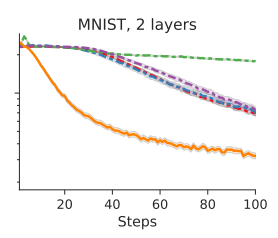

In [26]:
QUAD_LRS = [0.01, 0.003, 0.03, 1.0]
N_TESTS = 100

fit_data = np.zeros((N_TESTS, 200, len(OPT_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(MNISTLoss, MNISTNet2Layer, opt, lr=lr, n_tests=N_TESTS, n_epochs=200, **extra_kwargs))

fit_data[:, :, len(OPT_NAMES)] = np.array(get_fit_dict_test(N_TESTS, mnist_optimizer, None, MNISTLoss, MNISTNet2Layer, 1, 200, 200, out_mul=0.1, should_train=False))

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

optimizer:   0%|          | 0/100 [00:00<?, ?it/s]

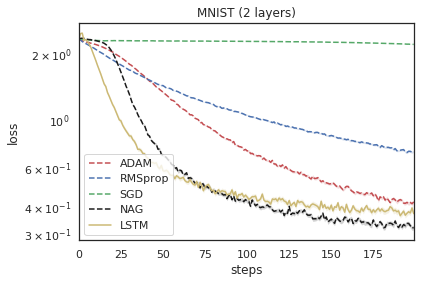

In [24]:

ax = sns.tsplot(data=fit_data[:, :, :], condition=OPT_NAMES + ['LSTM'], linestyle='--', color=['r', 'b', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('MNIST (2 layers)')
plt.show()

Same as above but for a single layer, 40 hidden unit network.

Paper comparison:
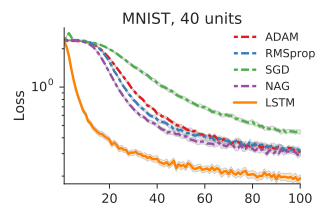

In [21]:
QUAD_LRS = [0.03, 0.01, 1.0, 1.0]
N_TESTS = 100

fit_data = np.zeros((N_TESTS, 200, len(OPT_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(MNISTLoss, MNISTNetBig, opt, lr=lr, n_tests=N_TESTS, n_epochs=200, **extra_kwargs))

fit_data[:, :, len(OPT_NAMES)] = np.array(get_fit_dict_test(N_TESTS, mnist_optimizer, None, MNISTLoss, MNISTNetBig, 1, 200, 200, out_mul=0.1, should_train=False))

In [5]:
fit_data = np.load('mnist-relu-fit.npy')
ax = sns.tsplot(data=fit_data[:, :, :], condition=OPT_NAMES + ['LSTM'], linestyle='--', color=['r', 'b', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('MNIST (40 hidden units)')
plt.show()

AttributeError: module 'seaborn' has no attribute 'tsplot'

Finally, same as above but with ReLU. As we shall see, the optimizer doesn't generalize very well to a different activation function, and so the other optimizers do much better. My reproduction shows this too although strangely my optimizer seems to do better than the one from the paper.

Original:
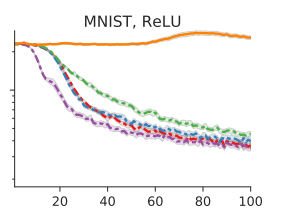

In [18]:
QUAD_LRS = [0.03, 0.003, 0.3, 0.3]
N_TESTS = 100

fit_data = np.zeros((N_TESTS, 200, len(OPT_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(MNISTLoss, MNISTRelu, opt, lr=lr, n_tests=N_TESTS, n_epochs=200, **extra_kwargs))

fit_data[:, :, len(OPT_NAMES)] = np.array(get_fit_dict_test(N_TESTS, mnist_optimizer, None, MNISTLoss, MNISTRelu, 1, 200, 200, out_mul=0.1, should_train=False))

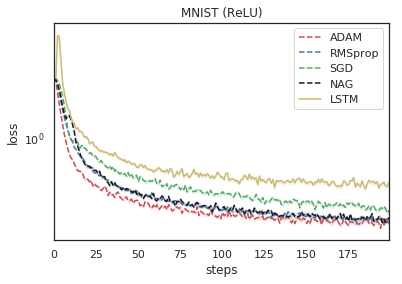

In [19]:
ax = sns.tsplot(data=fit_data[:, :, :], condition=OPT_NAMES + ['LSTM'], linestyle='--', color=['r', 'b', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('MNIST (ReLU)')
plt.show()